In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

plt.rc('font', family='Lato')

year = 2018

In [2]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'PWGTP', 'AGEP', 'WKW', 'WKHP', 'COW']
dtypes = {'ST': str, 'PUMA': str}
puma = lambda x: x['ST'] + x['PUMA']
ftfy = lambda x: np.where((x.WKW == 1) & (x.WKHP > 34), 1, 0)
emp = lambda x: np.where(x.COW.isin(range(1,9)), 1, 0)
pa = lambda x: np.where(x.AGEP.isin(range(25,55)), 1, 0)

files = ['data/psam_pusa_18.csv', 'data/psam_pusb_18.csv']

df = pd.concat(
    [(pd.read_csv(acs_dir / file, usecols=cols, dtype=dtypes)
        .query('PWGTP > 0')
        .assign(PUMA = puma, 
                FTFY = ftfy, 
                EMP = emp,
                PA = pa))
        [['PWGTP', 'PUMA', 'FTFY', 'EMP', 'PA']]
    for file in files]).astype({'PUMA': int})

df.head(3)

,PWGTP,PUMA,FTFY,EMP,PA
0,75,101600,0,1,0
1,75,101900,0,1,0
2,118,102000,1,1,1


In [3]:
# Match PUMAs to commuter zones (file from Dorn)
cz_match = pd.read_stata(acs_dir / 'data/cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

In [4]:
d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    emp_pop = 0
    ftfy_pop = 0   
    pa_pop = 0
    pa_emp_pop = 0
    pa_ftfy_pop = 0
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x.PWGTP * afactor))
        pop += data.WGT.sum()
        ftfy_pop += data.loc[data.FTFY == 1, 'WGT'].sum()
        emp_pop += data.loc[data.EMP == 1, 'WGT'].sum()
        pa_pop += data.loc[data.PA == 1, 'WGT'].sum()
        pa_emp_pop += data.loc[(data.PA == 1) & (data.EMP == 1), 'WGT'].sum()
        pa_ftfy_pop += data.loc[(data.PA == 1) & (data.FTFY == 1), 'WGT'].sum()
        
    fpop = ftfy_pop / pop
    epop = emp_pop / pop
    pa_epop = pa_emp_pop / pa_pop
    pa_ftfy = pa_ftfy_pop / pa_pop
    d[cz] = [fpop, epop, pop, pa_pop, pa_epop, pa_ftfy]
    
result = pd.DataFrame(d)
result.index = ['ftfy_share', 'emp_share', 'weight', 'pa_weight', 'pa_emp_share', 'pa_ftfy_share']
result = result.T

maxval = result.ftfy_share.max()
minval = result.ftfy_share.min()

In [5]:
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.winter_r
norm = Normalize(vmin=minval, vmax=maxval)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result.ftfy_share.values, 
              result.weight.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

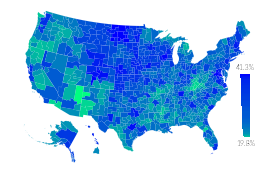

In [6]:
# Draw map
fig = plt.figure(figsize=(5.8,2.9))

m.drawmapboundary(color='white')
m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']][0]))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, fc=fc))
    
m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.05) 

ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='40%', loc=4, borderpad=2.8) 
for i, pt in enumerate(pct):
    rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                     fc=cmap(norm(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.text(0.58, 1.06, max_val, fontsize=7)
ax_inset.text(0.58, -0.14, min_val, fontsize=7)
ax_inset.axis('off')
plt.savefig(data_dir / 'acs_emp_map.pgf', bbox_inches='tight', transparent=True);

In [7]:
cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')
              .set_index('CZ90')
              .iloc[:, -1]
              .str.replace(' city', '')
              .str.replace(' town', '')
              .str.replace(' CDP', '')
              .str.replace(' \(remaind', '')
              .str.replace(' \(remain', '')
              .str.replace('Arlington, VA', 'Washington, DC')
              .to_dict())

In [8]:
size_cutoff = 100000

final = result.loc[result['weight'] > size_cutoff, 'ftfy_share'].sort_values()

final.index = final.index.map(cz_names)

In [9]:
print('\scriptsize{Top 10:} \\\*')
for i in [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    print(f'\\textbf{{{final[i]*100:.1f}\%}} \hspace{{1mm}} {final.index[i]} \\\*')
    if i == -10:
        print('')
        print('\scriptsize{Bottom 10:} \\\*')

\scriptsize{Top 10:} \\*
\textbf{41.2\%} \hspace{1mm} Bismarck, ND \\*
\textbf{40.9\%} \hspace{1mm} Madison, WI \\*
\textbf{40.8\%} \hspace{1mm} Washington, DC \\*
\textbf{40.1\%} \hspace{1mm} Denver, CO \\*
\textbf{39.9\%} \hspace{1mm} Austin, TX \\*
\textbf{39.8\%} \hspace{1mm} Glenwood Springs, CO \\*
\textbf{39.7\%} \hspace{1mm} Des Moines, IA \\*
\textbf{39.4\%} \hspace{1mm} Nashville-Davidson, TN \\*
\textbf{39.3\%} \hspace{1mm} Fargo, ND \\*
\textbf{39.1\%} \hspace{1mm} Fredericksburg, VA \\*

\scriptsize{Bottom 10:} \\*
\textbf{19.8\%} \hspace{1mm} Gallup, NM \\*
\textbf{22.4\%} \hspace{1mm} Hazard, KY \\*
\textbf{23.3\%} \hspace{1mm} Yuma, AZ \\*
\textbf{23.4\%} \hspace{1mm} Pikeville, KY \\*
\textbf{23.5\%} \hspace{1mm} Ocala, FL \\*
\textbf{23.6\%} \hspace{1mm} Corbin, KY \\*
\textbf{24.5\%} \hspace{1mm} Port Angeles, WA \\*
\textbf{24.6\%} \hspace{1mm} Greenville, MS \\*
\textbf{25.0\%} \hspace{1mm} Huntington, WV \\*
\textbf{25.0\%} \hspace{1mm} Altamont, OR \\*


In [10]:
tot = len(result)
thirdsh = (len(result.loc[result.ftfy_share > 0.333]) / tot) * 100

qtrtot = len(result.loc[result.ftfy_share <= 0.25])
qtrsh = (len(result.loc[result.ftfy_share <= 0.25]) / tot) * 100
qtrpop = result.loc[result.ftfy_share <= 0.25, 'weight'].sum() / 1_000_000

text = (f'In {year}, fewer than half ({thirdsh:.1f} percent) of commuter zones have at least '+
        'a third of their population working full-time and full-year. A total '+
        f'of {qtrtot} commuter zones (out of {tot}), covering {qtrpop:.1f} million '+
        'people, have a quarter of the population or less fully employed. ')

write_txt(text_dir / 'acs_ftfy_year.txt', str(year))
write_txt(text_dir / 'acs_ftfy_text.txt', text)

In [11]:
size_cutoff = 4_500_000

final2 = result.loc[result['weight'] > size_cutoff].sort_values('weight', ascending=False)

final2.index = final2.index.map(cz_names)

file = '/home/brian/Documents/uschartbook/chartbook/data/acs_emp_tables.tex'

((final2[['ftfy_share', 'emp_share', 'pa_ftfy_share', 'pa_emp_share']].round(3) * 100.0)
 .to_csv(file, sep='&', line_terminator='\\\ ', quotechar=' ', header=False, float_format='%.1f'))